# KNN Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

<Figure size 432x288 with 0 Axes>

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [8]:
def features_fn(obs, device): return torch.tensor(obs[['user_seq', 'movie_seq']].values).to(device)
def target_fn(obs, device):   return torch.tensor(obs['user_movie_rating'].values).to(device)

In [ ]:
dataset = ds.MovieLensTMDbJSONDataset(transform=features_fn, target_transform=target_fn, device=cpu)

In [10]:
user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
    data          = dataset.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)
# user_predictor.plot()

Building Ratting Matrix:   0%|          | 0/199791 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/13280 [00:00<?, ?it/s]

In [11]:
item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
    data          = dataset.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)
# item_predictor.plot()

Building Ratting Matrix:   0%|          | 0/199791 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/22081 [00:00<?, ?it/s]

In [12]:
ratings = np.unique(dataset.data.user_movie_rating.values)
ratings

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [45]:
discretizer = dr.round_sequence(
    ratings, 
    min_value = 0.5, 
    max_value = 5.0
)

validator = ml.Validator(
    n_samples  = 50,
    batch_size = 20,
    metrics    = [
        mt.RMSE(),
        mt.FBetaScore(beta=1, discretizer=discretizer, num_classes=len(ratings))
    ],
    predictors = [user_predictor, item_predictor]
)

In [46]:
summary = validator.validate(
    dataset,
    n_neighbors=5000
)

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Predictor: KNNItemBasedPredictor

Range: (0.093299999833107, 0.536300003528595)



<Figure size 1080x288 with 2 Axes>

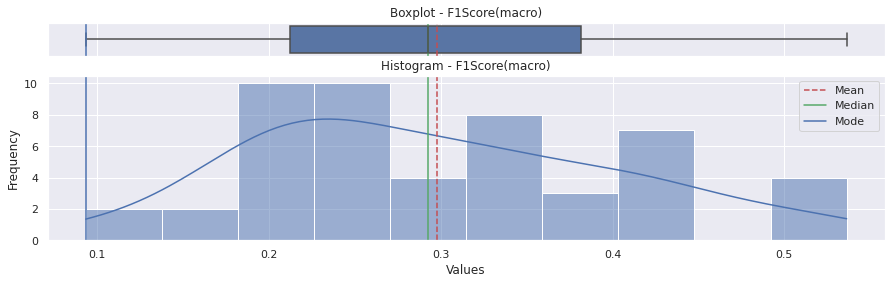


Metrics:



,F1Score(macro)
count,50.000000
mean,0.297626
std,0.106645
min,0.093300
25%,0.212425
50%,0.292300
75%,0.381900
max,0.536300


Predictor: KNNUserBasedPredictor

Range: (0.07039999961853027, 0.5472000241279602)



<Figure size 1080x288 with 2 Axes>

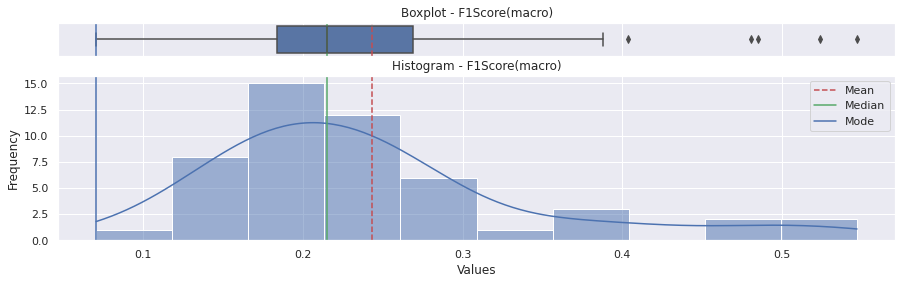


Metrics:



,F1Score(macro)
count,50.000000
mean,0.242974
std,0.104201
min,0.070400
25%,0.183575
50%,0.215250
75%,0.268850
max,0.547200


Predictor: KNNItemBasedPredictor

Range: (0.5328999757766724, 1.9836000204086304)



<Figure size 1080x288 with 2 Axes>

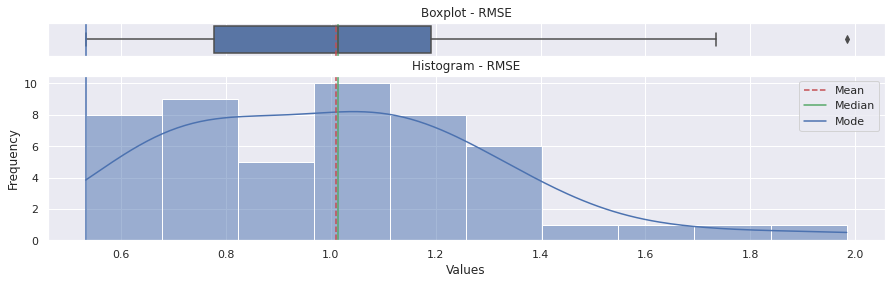


Metrics:



,RMSE
count,50.000000
mean,1.010346
std,0.310263
min,0.532900
25%,0.776475
50%,1.014750
75%,1.192025
max,1.983600


Predictor: KNNUserBasedPredictor

Range: (0.6104000210762024, 1.7283999919891357)



<Figure size 1080x288 with 2 Axes>

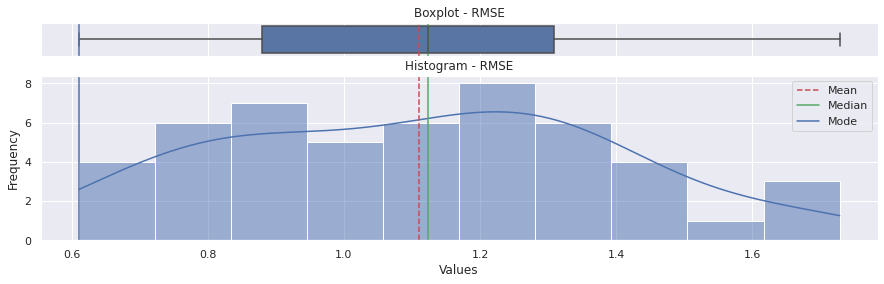


Metrics:



,RMSE
count,50.000000
mean,1.110994
std,0.288942
min,0.610400
25%,0.880125
50%,1.124150
75%,1.309000
max,1.728400


In [47]:
summary.plot()

In [48]:
validator = ml.Validator(
    n_samples  = 10,
    batch_size = 3000,
    metrics    = [
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanAveragePrecisionAtk(user_index=0, k=10, discretizer=dr.between(4, 5)),
        mt.MeanAveragePrecisionAtk(user_index=0, k=10, discretizer=dr.between(4, 5))
    ],
    predictors = [user_predictor, item_predictor]
)

In [49]:
summary = validator.validate(
    dataset, 
    n_neighbors=1000
)

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

2022-05-04 00:52:03,710 - INFO - n_users_found: 103
2022-05-04 00:52:03,727 - INFO - n_users_found: 24
2022-05-04 00:52:03,743 - INFO - n_users_found: 24
2022-05-04 00:53:19,145 - INFO - n_users_found: 103
2022-05-04 00:53:19,163 - INFO - n_users_found: 24
2022-05-04 00:53:19,183 - INFO - n_users_found: 24
2022-05-04 00:54:36,178 - INFO - n_users_found: 101
2022-05-04 00:54:36,202 - INFO - n_users_found: 24
2022-05-04 00:54:36,219 - INFO - n_users_found: 24
2022-05-04 00:55:51,329 - INFO - n_users_found: 101
2022-05-04 00:55:51,347 - INFO - n_users_found: 24
2022-05-04 00:55:51,364 - INFO - n_users_found: 24
2022-05-04 00:57:07,439 - INFO - n_users_found: 113
2022-05-04 00:57:07,457 - INFO - n_users_found: 26
2022-05-04 00:57:07,474 - INFO - n_users_found: 26
2022-05-04 00:58:22,928 - INFO - n_users_found: 113
2022-05-04 00:58:22,946 - INFO - n_users_found: 26
2022-05-04 00:58:22,964 - INFO - n_users_found: 26
2022-05-04 00:59:39,688 - INFO - n_users_found: 100
2022-05-04 00:59:39,706 

Predictor: KNNItemBasedPredictor

Range: (0.42660000920295715, 0.4645000100135803)



<Figure size 1080x288 with 2 Axes>

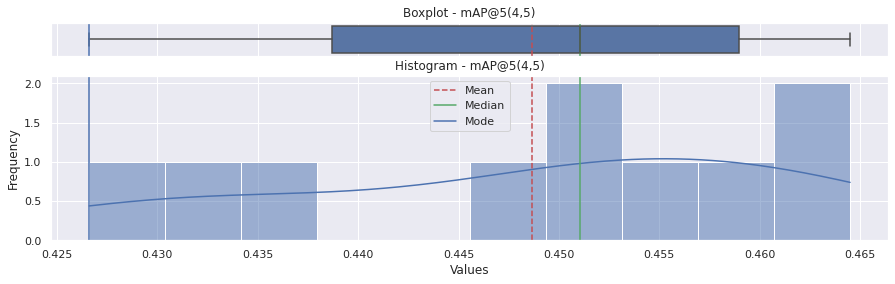


Metrics:



,"mAP@5(4,5)"
count,10.000000
mean,0.448660
std,0.013007
min,0.426600
25%,0.438700
50%,0.451050
75%,0.458975
max,0.464500


Predictor: KNNUserBasedPredictor

Range: (0.4293999969959259, 0.49570000171661377)



<Figure size 1080x288 with 2 Axes>

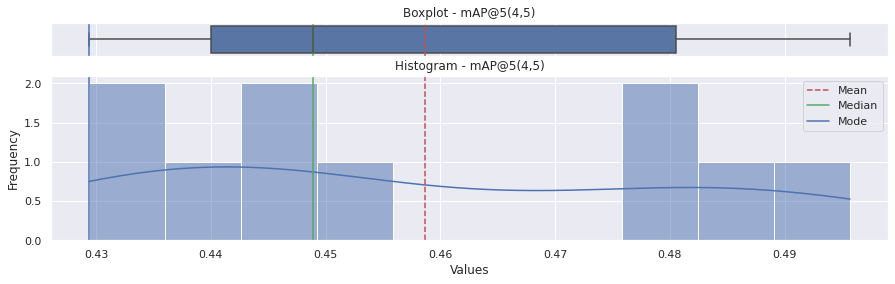


Metrics:



,"mAP@5(4,5)"
count,10.000000
mean,0.458650
std,0.024384
min,0.429400
25%,0.440025
50%,0.448950
75%,0.480575
max,0.495700


Predictor: KNNItemBasedPredictor

Range: (0.2831999957561493, 0.359499990940094)



<Figure size 1080x288 with 2 Axes>

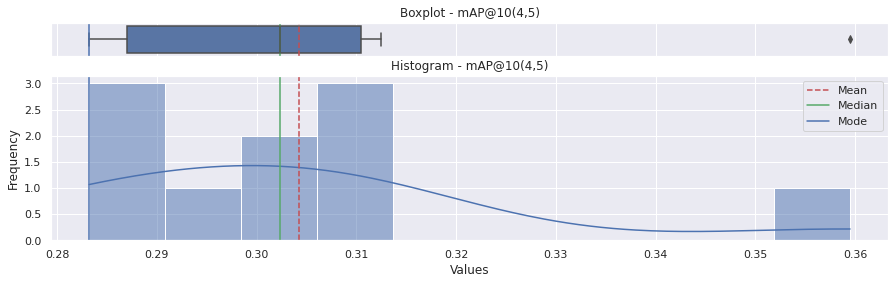


Metrics:



,"mAP@10(4,5)"
count,10.000000
mean,0.304290
std,0.022520
min,0.283200
25%,0.287025
50%,0.302350
75%,0.310450
max,0.359500


Predictor: KNNUserBasedPredictor

Range: (0.2948000133037567, 0.3580000102519989)



<Figure size 1080x288 with 2 Axes>

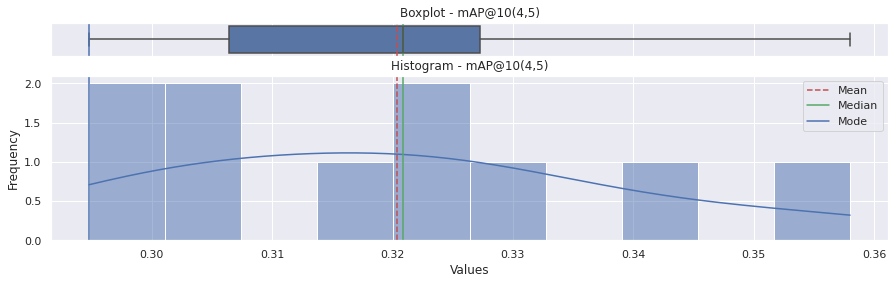


Metrics:



,"mAP@10(4,5)"
count,10.000000
mean,0.320390
std,0.019602
min,0.294800
25%,0.306400
50%,0.320900
75%,0.327275
max,0.358000


In [50]:
summary.plot()